Authors:
<br />
Arsh Lalani, Faculty of Engineering, Western University 
<br />
Andrew Harrop, Faculty of Engineering, Western University

External Libraries:

In [1]:
from sklearn.model_selection import train_test_split
import cv2
import numpy as np
import imutils

import matplotlib.pyplot as plt

from tensorflow.keras.applications.vgg16 import VGG16, preprocess_input
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.preprocessing import LabelBinarizer
from tensorflow.keras.utils import to_categorical




Internal Libraries:

In [2]:
# Internal libraries:
from Helpers.load_images import load_images

from Helpers.preprocessing import multiple_dataset_conversion
from Helpers.preprocessing import crop_images
from Helpers.preprocessing import preprocess_images
from Helpers.preprocessing import augment_image_set
from Helpers.preprocessing import labels_to_categorical

from Helpers.plotting import plot_image_classes
from Helpers.plotting import plot_history
from Helpers.plotting import plot_image
from Helpers.plotting import plot_augmented

from Helpers.evaluate import evalute_model


from Models.CNN import build_cnn 
from Models.CNN import train_cnn 

from Models.VGG16 import build_vgg16 
from Models.VGG16 import train_vgg16

from Models.RESNET import build_resnet
from Models.RESNET import train_resnet



Load images from the dataset

In [3]:
dataset_1_tumor_images, dataset_1_normal_images = load_images(1)
dataset_2_tumor_images, dataset_2_normal_images = load_images(2)

Plot random images:

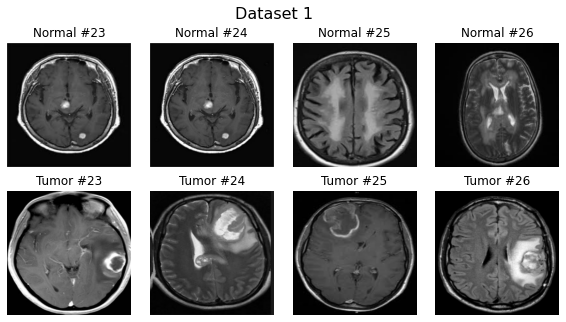

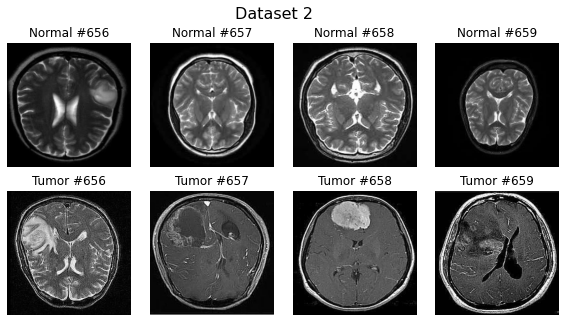

In [4]:
plot_image_classes(dataset_1_normal_images, dataset_1_tumor_images, n_images=4, title="Dataset 1")
plot_image_classes(dataset_2_normal_images, dataset_2_tumor_images, n_images=4, title="Dataset 2")

Crop the brain into the full view

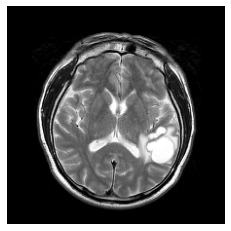

/Users/andrew/Desktop/School/CS4442/Final/CodingEnv/Advanced-AI-Thesis/Helpers/preprocessing.py:111: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array(cropped_images)


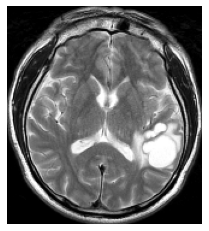

In [5]:
plot_image(dataset_1_tumor_images[4], save="uncropped_test")
dataset_1_tumor_images_proc = crop_images(dataset_1_tumor_images)
dataset_1_normal_images_proc = crop_images(dataset_1_normal_images)
dataset_2_tumor_images_proc = crop_images(dataset_2_tumor_images)
dataset_2_normal_images_proc = crop_images(dataset_2_normal_images)

test_image = dataset_1_tumor_images_proc[4]
plot_image(test_image, save="cropped_test")

In [6]:
dataset_1_normal_images_proc = preprocess_images(dataset_1_normal_images_proc, (224, 224))
dataset_1_tumor_images_proc = preprocess_images(dataset_1_tumor_images_proc, (224, 224))
dataset_2_normal_images_proc = preprocess_images(dataset_2_normal_images_proc, (224, 224))
dataset_2_tumor_images_proc = preprocess_images(dataset_2_tumor_images_proc, (224, 224))

Split the datasets. The light dataset contains many fewer images, which is convenient for testing preliminary models.

In [7]:
X, Y = multiple_dataset_conversion(yes = [dataset_1_normal_images_proc, dataset_2_normal_images_proc], no = [dataset_1_tumor_images_proc, dataset_2_tumor_images_proc])
X_light, Y_light = multiple_dataset_conversion(yes = [dataset_1_normal_images], no = [dataset_1_tumor_images])

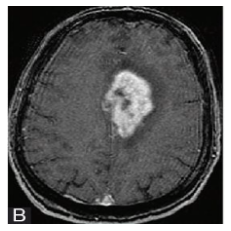

In [8]:
# Sp;it into train, test, and validation sets
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=42, stratify=Y)
X_test, X_val, Y_test, Y_val = train_test_split(X_test, Y_test, test_size=0.5, random_state=42, stratify=Y_test)

X_light_train, X_light_test, Y_light_train, Y_light_test = train_test_split(X_light, Y_light, test_size=0.2, random_state=42, stratify=Y_light)
X_light_test, X_light_val, Y_light_test, Y_light_val = train_test_split(X_light_test, Y_light_test, test_size=0.5, random_state=42, stratify=Y_light_test)

plot_image(X_light_train[0], save="X_light_train")

Preform some data augmentation on the training data

In [9]:
example_datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.08,
    height_shift_range=0.08,
    rescale=1./255,
    shear_range=0.1,
    brightness_range=[0.5, 1.5],
    horizontal_flip=True,
    vertical_flip=True
)


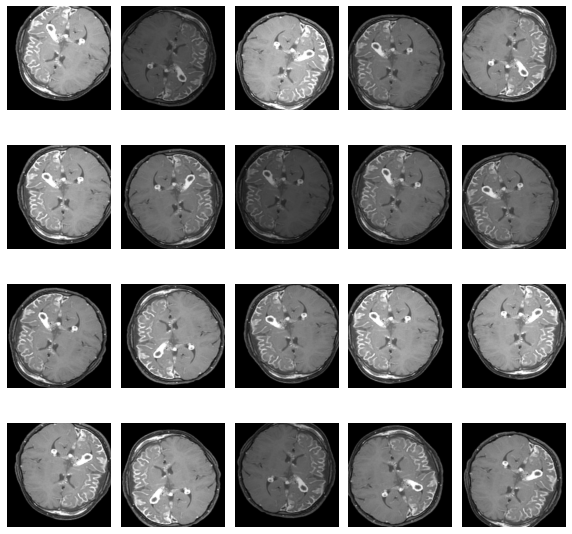

In [10]:
plot_augmented(X_light_train[5], example_datagen)

In [11]:
# Applting augmentation to the training set
train_datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.08,
    height_shift_range=0.08,
    rescale=1./255,
    shear_range=0.1,
    brightness_range=[0.5, 1.5],
    horizontal_flip=True,
    vertical_flip=True,
    preprocessing_function=preprocess_input
)

test_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input
)




        

In [12]:
X_train = np.array(X_train)
Y_train = labels_to_categorical(np.array(Y_train))

X_test = np.array(X_test)
Y_test = labels_to_categorical(np.array(Y_test))

X_val = np.array(X_val)
Y_val = labels_to_categorical(np.array(Y_val))

X_light_train = np.array(X_light_train)
Y_light_train = labels_to_categorical(np.array(Y_light_train))

X_light_test = np.array(X_light_test)
Y_light_test = labels_to_categorical(np.array(Y_light_test))

X_light_val = np.array(X_light_val)
Y_light_val = labels_to_categorical(np.array(Y_light_val))

train_generator = train_datagen.flow(X_train, Y_train, batch_size=32)
test_generator = test_datagen.flow(X_test, Y_test, batch_size=16)
validation_generator = test_datagen.flow(X_val, Y_val, batch_size=16)

train_light_generator = train_datagen.flow(X_light_train, Y_light_train, batch_size=8)
test_light_generator = test_datagen.flow(X_light_test, Y_light_test, batch_size=4)
validation_light_generator = test_datagen.flow(X_light_val, Y_light_val, batch_size=4)

Data is now ready to be used for training.

Model 1 is a simple CNN, no fancy model here.

In [13]:
model_1 = build_cnn()
model_1.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 zero_padding2d (ZeroPadding  (None, 228, 228, 3)      0         
 2D)                                                             
                                                                 
 conv2d (Conv2D)             (None, 222, 222, 32)      4736      
                                                                 
 batch_normalization (BatchN  (None, 222, 222, 32)     128       
 ormalization)                                                   
                                                                 
 activation (Activation)     (None, 222, 222, 32)      0         
                                                                 
 max_pooling2d (MaxPooling2D  (None, 55, 55, 32)       0     

2022-04-08 14:20:18.285783: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [17]:
history_1 = train_cnn(model_1, X_train, Y_train, X_val, Y_val, epochs=20, batch_size=32)

Epoch 1/20
82/82 [==============================] - 101s 1s/step - loss: 0.2541 - accuracy: 0.9008 - val_loss: 0.2780 - val_accuracy: 0.8988
Epoch 2/20
82/82 [==============================] - 102s 1s/step - loss: 0.2415 - accuracy: 0.9085 - val_loss: 0.2503 - val_accuracy: 0.8926
Epoch 3/20
82/82 [==============================] - 103s 1s/step - loss: 0.2385 - accuracy: 0.9001 - val_loss: 0.2316 - val_accuracy: 0.9172
Epoch 4/20
82/82 [==============================] - 105s 1s/step - loss: 0.2152 - accuracy: 0.9181 - val_loss: 0.2290 - val_accuracy: 0.9172
Epoch 5/20
82/82 [==============================] - 105s 1s/step - loss: 0.1613 - accuracy: 0.9435 - val_loss: 0.2093 - val_accuracy: 0.9172
Epoch 6/20
82/82 [==============================] - 107s 1s/step - loss: 0.1813 - accuracy: 0.9281 - val_loss: 0.2546 - val_accuracy: 0.9202
Epoch 7/20
82/82 [==============================] - 103s 1s/step - loss: 0.1523 - accuracy: 0.9462 - val_loss: 0.2018 - val_accuracy: 0.9294
Epoch 8/20
82

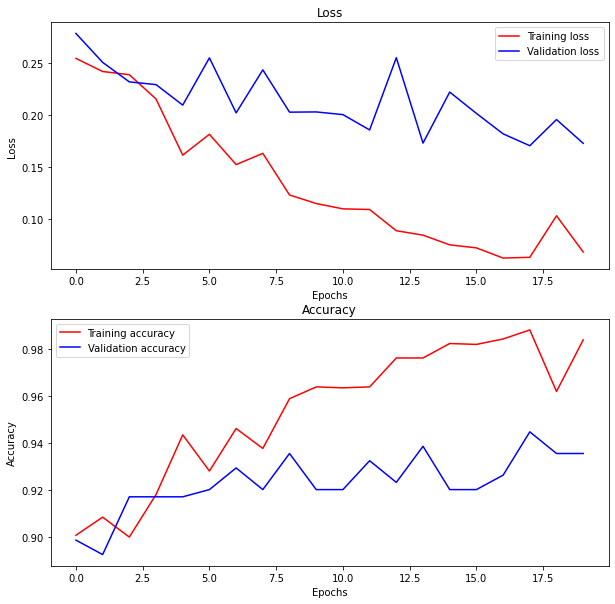

In [23]:
plot_history(history_1)

In [24]:
evalute_model(model_1, X_test, Y_test, batch_size=32)

Actuals: [1 0 0 0 0 0 1 0 1 1 1 1 0 1 0 0 1 0 0 1 0 0 1 0 1 0 1 0 0 1 1 1 1 1 0 1 1
 0 1 0 1 1 1 0 0 0 0 0 0 1 1 1 0 1 1 0 0 1 1 1 1 1 0 1 0 1 0 1 0 1 1 0 0 1
 0 1 0 0 0 0 0 0 0 1 0 1 0 0 0 1 1 1 0 1 0 1 0 1 0 0 1 1 0 0 0 1 0 1 1 0 0
 0 1 0 1 1 0 1 0 0 1 0 0 1 0 1 0 1 1 1 1 1 0 0 1 0 1 1 0 0 1 1 0 0 0 1 0 0
 0 0 1 1 0 1 1 0 1 1 1 0 1 0 0 0 0 0 0 0 1 0 1 1 1 0 0 1 1 0 0 0 1 1 0 1 0
 0 1 0 0 1 0 0 0 0 0 1 1 0 1 0 0 1 1 1 0 1 0 0 0 1 0 0 1 1 1 1 1 0 1 0 0 0
 1 1 0 0 0 1 0 1 0 1 1 1 1 1 0 1 1 1 0 0 0 1 1 0 0 1 1 1 0 1 0 0 0 1 1 1 1
 0 1 1 1 0 1 0 0 1 0 0 0 0 0 1 1 1 0 0 0 0 1 0 1 0 0 0 1 0 1 0 0 0 0 1 1 1
 0 1 1 1 1 1 0 0 1 0 0 1 1 1 0 1 1 1 0 1 0 0 1 1 1 1 0 1 1]
Predictions: [1 0 0 0 0 0 1 0 0 1 1 1 0 1 0 1 1 0 0 1 0 0 1 0 1 0 1 0 0 1 1 0 1 1 0 1 1
 0 1 0 1 1 1 0 0 1 0 0 0 1 1 1 0 1 1 0 0 1 1 1 1 1 0 1 0 1 0 1 1 1 1 0 0 0
 0 1 0 0 0 0 1 0 0 1 0 1 0 0 0 1 1 1 0 1 0 1 0 1 0 0 1 1 0 0 0 1 0 1 1 0 0
 0 1 0 1 1 0 1 0 0 1 0 0 1 0 1 0 1 1 1 1 1 0 0 1 0 1 1 0 0 1 1 0 0 0 1 0 0
 0 0 1 0 0 1 1 0 1

(0.9538461538461539,
 array([[159,   6],
        [  9, 151]]))

In [20]:
# Save model
model_1.save("model_1.h5")

VGG 16

In [ ]:
model_2 = build_vgg16()
model_2.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 7, 7, 512)         14714688  
                                                                 
 flatten_1 (Flatten)         (None, 25088)             0         
                                                                 
 dropout (Dropout)           (None, 25088)             0         
                                                                 
 dense_1 (Dense)             (None, 2)                 50178     
                                                                 
Total params: 14,764,866
Trainable params: 50,178
Non-trainable params: 14,714,688
_________________________________________________________________


/Users/andrew/opt/anaconda3/envs/tf/lib/python3.10/site-packages/keras/optimizer_v2/rmsprop.py:130: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(RMSprop, self).__init__(name, **kwargs)


In [ ]:
history_2 = train_vgg16(model_2, train_light_generator,validation_light_generator, epochs=5)

NameError: name 'train_vgg16' is not defined

In [ ]:
history_2.history

{'loss': [0.7762693166732788, 0.7395764589309692],
 'accuracy': [0.6034482717514038, 0.5517241358757019],
 'val_loss': [3.662588596343994, 5.213818073272705],
 'val_accuracy': [0.5, 0.75]}

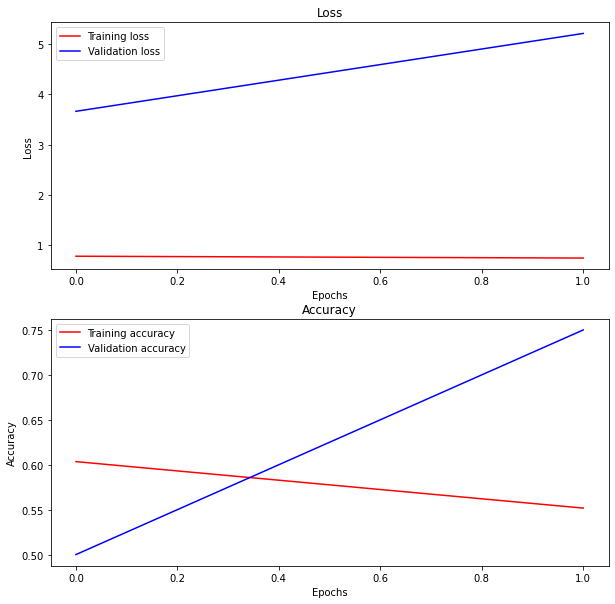

In [ ]:
plot_history(history_2)

In [ ]:
# Evaluate the model
evalute_model(model_2, X_light_test, Y_light_test, batch_size=5)


NameError: name 'evalute_model' is not defined

RESNET

In [21]:
model_3 = build_resnet()

/Users/andrew/opt/anaconda3/envs/tf/lib/python3.10/site-packages/keras/optimizer_v2/gradient_descent.py:102: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(SGD, self).__init__(name, **kwargs)


In [22]:
history_3 = train_resnet(model_3, X_train, Y_train, X_val, Y_val, epochs=20)

Epoch 1/20
326/326 [==============================] - 184s 559ms/step - loss: 0.4768 - accuracy: 0.8128 - val_loss: 0.3369 - val_accuracy: 0.8957
Epoch 2/20
326/326 [==============================] - 185s 568ms/step - loss: 0.2890 - accuracy: 0.9135 - val_loss: 0.2512 - val_accuracy: 0.9264
Epoch 3/20
326/326 [==============================] - 180s 553ms/step - loss: 0.2338 - accuracy: 0.9235 - val_loss: 0.2124 - val_accuracy: 0.9325
Epoch 4/20
326/326 [==============================] - 179s 549ms/step - loss: 0.2039 - accuracy: 0.9312 - val_loss: 0.1866 - val_accuracy: 0.9479
Epoch 5/20
326/326 [==============================] - 182s 559ms/step - loss: 0.1844 - accuracy: 0.9389 - val_loss: 0.1697 - val_accuracy: 0.9540
Epoch 6/20
326/326 [==============================] - 183s 562ms/step - loss: 0.1704 - accuracy: 0.9443 - val_loss: 0.1543 - val_accuracy: 0.9509
Epoch 7/20
326/326 [==============================] - 185s 567ms/step - loss: 0.1580 - accuracy: 0.9504 - val_loss: 0.1434 -

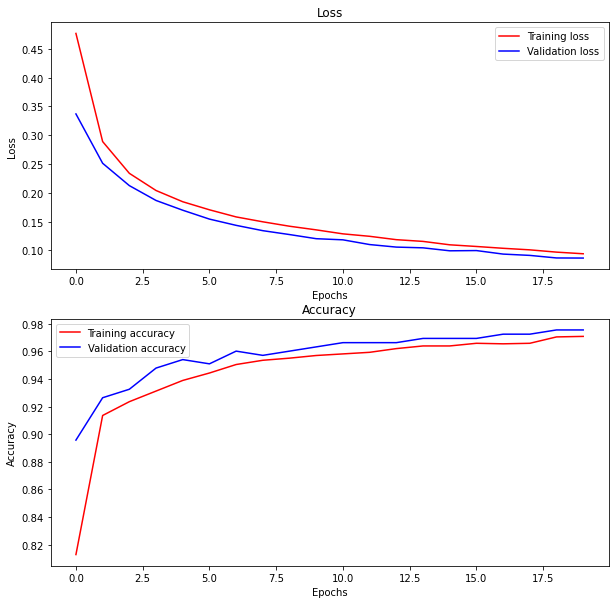

In [25]:
plot_history(history_3)

In [26]:
# Evaluate the model
evalute_model(model_3, X_test, Y_test, batch_size=32)

Actuals: [1 0 0 0 0 0 1 0 1 1 1 1 0 1 0 0 1 0 0 1 0 0 1 0 1 0 1 0 0 1 1 1 1 1 0 1 1
 0 1 0 1 1 1 0 0 0 0 0 0 1 1 1 0 1 1 0 0 1 1 1 1 1 0 1 0 1 0 1 0 1 1 0 0 1
 0 1 0 0 0 0 0 0 0 1 0 1 0 0 0 1 1 1 0 1 0 1 0 1 0 0 1 1 0 0 0 1 0 1 1 0 0
 0 1 0 1 1 0 1 0 0 1 0 0 1 0 1 0 1 1 1 1 1 0 0 1 0 1 1 0 0 1 1 0 0 0 1 0 0
 0 0 1 1 0 1 1 0 1 1 1 0 1 0 0 0 0 0 0 0 1 0 1 1 1 0 0 1 1 0 0 0 1 1 0 1 0
 0 1 0 0 1 0 0 0 0 0 1 1 0 1 0 0 1 1 1 0 1 0 0 0 1 0 0 1 1 1 1 1 0 1 0 0 0
 1 1 0 0 0 1 0 1 0 1 1 1 1 1 0 1 1 1 0 0 0 1 1 0 0 1 1 1 0 1 0 0 0 1 1 1 1
 0 1 1 1 0 1 0 0 1 0 0 0 0 0 1 1 1 0 0 0 0 1 0 1 0 0 0 1 0 1 0 0 0 0 1 1 1
 0 1 1 1 1 1 0 0 1 0 0 1 1 1 0 1 1 1 0 1 0 0 1 1 1 1 0 1 1]
Predictions: [1 0 0 0 0 0 1 0 0 1 0 1 0 1 0 0 1 0 0 1 0 0 1 0 1 0 1 0 0 1 1 1 1 1 0 1 1
 0 1 0 1 0 1 0 0 0 0 0 0 1 1 1 0 1 1 0 0 1 1 1 1 1 0 1 0 1 0 1 0 1 1 0 0 0
 0 1 0 0 0 0 0 0 0 1 0 1 0 0 0 1 1 1 0 1 0 1 0 1 0 0 1 1 0 0 0 1 0 1 1 0 0
 0 1 0 1 1 0 1 0 0 1 0 0 1 0 1 0 0 1 1 1 0 0 0 1 0 1 1 0 0 1 1 0 0 0 1 0 0
 0 0 1 0 0 1 1 0 1

(0.963076923076923,
 array([[163,   2],
        [ 10, 150]]))

In [27]:
# Save model
model_3.save("model_3.h5")


/Users/andrew/opt/anaconda3/envs/tf/lib/python3.10/site-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
